In [1]:
# imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
# for each row, add n empty ones
def df_add_rows(df, n):
    empty_rows = n
    df.index = range(0, empty_rows*len(df), empty_rows)
    df_out = df.reindex(index=range(empty_rows*len(df)))
    return df_out

In [3]:
def generate_time_series(start_date_str, end_date_str, interval_min):
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M")
    interval = timedelta(hours=interval_min/60)
    output = []
    while start_date <= end_date:
        output.append(start_date.strftime("%Y-%m-%d %H:%M"))
        start_date += interval
    return output

Price data

In [4]:
# navigate to price files
os.chdir("C:\\Users\\joche\\FIM Kernkompetenzzentrum\\Projekt VIdES - Dokumente\\General\\07_Arbeitsordner\\02_Daten_und_Simulationsvorbereitung\\Strompreise\\historische strompreise")

,count,mean,std,min,25%,50%,75%,max
price_2016,8761.0,28.964373,12.484463,-130.09,22.310,28.230,34.95,104.96
price_2017,8760.0,34.188527,17.659501,-83.06,27.780,33.825,40.57,163.52
price_2018,8760.0,44.468920,17.771203,-76.01,34.455,45.090,54.87,128.26
price_2019,8760.0,37.666600,15.517500,-90.01,31.060,38.060,46.27,121.46
price_2020,8761.0,30.432294,17.489462,-83.94,21.710,30.960,40.20,200.04


<AxesSubplot:>

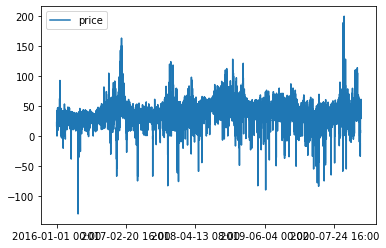

In [5]:
# read in and display historic price data

# create dummy series and df to append to
series = pd.Series(dtype="float64")
df = pd.read_csv(os.listdir()[0])
for i in os.listdir():
    # extract column name from file name
    s = "price_"
    s += i.split(".",2)[0][-4:]
    # read in file
    tmp = pd.read_csv(i, header=None)
    # assign to series
    series = pd.concat([series, tmp.iloc[:,0]])
    # assign to df
    tmp.set_axis([s], axis=1, inplace=True)
    df[s] = tmp
# disregard first column of df since it's a duplicate
df_price = df.iloc[:,1:]
# truncate at index 8760
df_price = df_price.truncate(after=8760)
# add mean column
df_price['price_2016-2020_mean'] = df_price.iloc[:,:5].mean(axis=1)
# interpolate missing values (at the end)
df_price.interpolate()
# summary statistics of df_price
display(df_price.iloc[:,:-1].describe().transpose())

# reset series index, transform to df, and rename column
df_price_series = pd.DataFrame(series.reset_index()[0])
df_price_series.columns = ["price"]
#df_price_series = df_price_series.columns = ["price"]
# insert two empty rows and interpolate missing values
df_price_series.loc[df_price_series.shape[0]] = [np.nan]
df_price_series.loc[df_price_series.shape[0]] = [np.nan]
df_price_series.interpolate(inplace=True)
# generate hourly time series from 2016 to 2020
time_series = generate_time_series(start_date_str="2016-01-01 00:00", end_date_str="2020-12-31 23:00", interval_min=60)
# transform time series to df
df_time_series = pd.DataFrame(time_series, index=time_series)
# assign index of df_time_series to price_series
df_price_series.index = df_time_series.index
# plot
display(df_price_series.plot())


PV load data

In [11]:
# navigate to pv and wind load profile file
os.chdir('C:\\Users\\joche\\FIM Kernkompetenzzentrum\\Projekt VIdES - Dokumente\\General\\07_Arbeitsordner\\02_Daten_und_Simulationsvorbereitung\\Strompreise')
file1 = "2022 06 07 Strompreise.xlsx"
file2 = "pv_wind_load_timeseries.xlsx"
df_pv = pd.read_excel(file1, sheet_name="pv_load_profiles")
df_wind = pd.read_excel(file1, sheet_name="wind_load_profiles")
df_pv_series = pd.read_excel(file2, sheet_name="pv")
df_wind_series = pd.read_excel(file2, sheet_name="wind")

In [12]:
# set datetime as index, cut out cap_factors
df_pv_series

,datetime,pv_cap_factor,pv_load_mwh
0,2016-01-01 00:00:00,0.0,0.0
1,2016-01-01 01:00:00,0.0,0.0
2,2016-01-01 02:00:00,0.0,0.0
3,2016-01-01 03:00:00,0.0,0.0
4,2016-01-01 04:00:00,0.0,0.0
...,...,...,...
43843,2020-12-31 19:00:00,0.0,0.0
43844,2020-12-31 20:00:00,0.0,0.0
43845,2020-12-31 21:00:00,0.0,0.0
43846,2020-12-31 22:00:00,0.0,0.0


In [7]:
#
df_pv

,index,datetime,pv_2016_mw,pv_2017_mw,pv_2018_mw,pv_2019_mw,pv_2020_mw,pv_2030_mw
0,1,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8755,8756,2019-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0
8756,8757,2019-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0
8757,8758,2019-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0
8758,8759,2019-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# add mean column
df_pv['pv_2016-2020_mean'] = df_pv.iloc[:,2:7].mean(axis=1)
df_pv

,index,datetime,pv_2016_mw,pv_2017_mw,pv_2018_mw,pv_2019_mw,pv_2020_mw,pv_2030_mw,pv_2016-2020_mean
0,1,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
8755,8756,2019-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,8757,2019-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,8758,2019-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8758,8759,2019-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# add mean column
df_wind['wind_2016-2020_mean'] = df_wind.iloc[:,2:7].mean(axis=1)
df_wind

,index,datetime,wind_2016_mw,wind_2017_mw,wind_2018_mw,wind_2019_mw,wind_2020_mw,wind_2030_mw,wind_2016-2020_mean
0,1,2019-01-01 00:00:00,15742.7730,16367.3910,17476.1460,18981.1890,20839.1760,77400.0,17881.3350
1,2,2019-01-01 01:00:00,17593.6675,18291.7225,19530.8350,21212.8275,23289.2600,86500.0,19983.6625
2,3,2019-01-01 02:00:00,19558.4632,20334.4744,21711.9664,23581.7976,25890.1184,96160.0,22215.3640
3,4,2019-01-01 03:00:00,20636.4567,21455.2389,22908.6534,24881.5431,27317.0904,101460.0,23439.7965
4,5,2019-01-01 04:00:00,22690.7462,23591.0354,25189.1324,27358.4166,30036.4144,111560.0,25773.1490
...,...,...,...,...,...,...,...,...,...
8755,8756,2019-12-31 19:00:00,6114.0537,6356.6379,6787.2474,7371.7641,8093.3544,30060.0,6944.6115
8756,8757,2019-12-31 20:00:00,5109.2824,5312.0008,5671.8448,6160.3032,6763.3088,25120.0,5803.3480
8757,8758,2019-12-31 21:00:00,4417.7394,4593.0198,4904.1588,5326.5042,5847.8928,21720.0,5017.8630
8758,8759,2019-12-31 22:00:00,3856.3692,4009.3764,4280.9784,4649.6556,5104.7904,18960.0,4380.2340


In [137]:
# x: pv_mean and wind_mean
x = pd.concat([df_pv[['pv_2016-2020_mean']],df_wind[['wind_2016-2020_mean']]],axis=1)
# y: price_mean
y = df_price[["price_2016-2020_mean"]].iloc[:-1,:]
tt = pd.concat([y,x], axis=1)

In [142]:
a = x.iloc[1:2,1:]
a.shape
b = y[1:2]
b.shape

(1, 1)

,price_2016-2020_mean
1,1.012


In [143]:
lm = sm.OLS(b,a)
res = lm.fit()
print(res.summary())

ValueError: resids must contain at least 2 elements

In [141]:
print('a:\n', a)
print("pred:\n", res.predict(a))
print("true:\n", b)

a:
    pv_2016-2020_mean  wind_2016-2020_mean
1                0.0           19983.6625
2                0.0           22215.3640
pred:
 1   -0.489088
2   -0.543708
dtype: float64
true:
    price_2016-2020_mean
1                 1.012
2                -1.894
